# 【例題2.4】 漸変不等流の一次元解析法

標準逐次近似法，直接逐次近似法，Runge-Kutta-Gill（ルンゲ-クッタ-ギル）法による漸変不等流の一次元解析を実施するプログラムです．

## プログラムに必要なライブラリと定数の設定

In [2]:
"""【例題2.4】 漸変不等流の一次元解析法."""
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
# 以下プログラム
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsc
import scipy.optimize
# 定数の設定
GRAVITY_ACCELERATION: float = 9.81  # 重力加速度
EPS: float = 1e-4  # 差の閾値
SHEET1_NAME = "計算条件"  # 入力データのシート名
SHEET2_NAME = "水路形状"  # 入力データのシート名

## 入力条件や定数を設定するクラス

● 擬似等流水深
  
$I_b-\frac{n^2Q^2}{R^{4/3}A^2}+\frac{Q^2}{gA^3}\frac{\partial A}{\partial B}\cdot \frac{\partial B}{\partial x} = 0$　


 ↓
　
 
 $I_b-\frac{n^2Q^2}{R^{4/3}A^2}+\frac{Q^2}{gA^3}h\cdot \frac{\partial B}{\partial x} = 0$　

上式を満たす水深$h$を繰り返し計算により求める．
 

● 限界水深

$\frac{Q^2}{gA^3}\frac{\partial A}{\partial h}=\frac{Q^2 B}{gA^3}=1$．


$h_c = \left(\frac{Q^2}{gB^2}\right)^{1/3}$

上式より求める．

In [3]:
class SetData:
    """入力条件や定数を設定するクラス."""

    def __init__(self, _inputFileName):
        """ファイルの読み込みと変数の設定."""
        self.data = pd.read_excel(_inputFileName, sheet_name=None)

    def setValue(self):
        """数値の取得."""
        # 各データをnumpy形式に変換
        # 計算条件の読み込み
        print(self.data[SHEET1_NAME])
        __colName = self.data[SHEET1_NAME].columns
        # 数値の取得
        self.Q = self.data[SHEET1_NAME][__colName[1]][0]  # 流量
        self.n = self.data[SHEET1_NAME][__colName[1]][1]  # 粗度係数
        self.Wldown = self.data[SHEET1_NAME][__colName[1]][2]  # 下流端水位
        # 水路形状データの読み込み
        # 行数の取得
        __len = len(self.data[SHEET2_NAME])
        # dataの確認
        print(self.data[SHEET2_NAME])
        __colName = self.data[SHEET2_NAME].columns
        self.x = self.__getChannelData(__colName[0])
        self.zb = self.__getChannelData(__colName[1])
        self.B = self.__getChannelData(__colName[2])
        # その他の諸量の計算
        self.secNo = [i+1 for i in range(len(self.x)-1, -1, -1)]
        self.dx = self.x[1:]-self.x[:-1]  # 刻み幅 dx
        self.Ib = -self.__calc_dadx(self.zb)+0.0  # 水路床勾配の計算 -dzb/dx
        self.dBdx = self.__calc_dadx(self.B)+0.0   # 水路幅勾配　dB/dx
        # x0,擬似等流水深　h0', 水位
        (self.x0, self.h0, self.wl0) = self.__calc_h0(__len)
        self.hc = self.__calc_hc()  # 限界水深hc

    # 擬似等流水深を求める式の計算
    def __normalDepth(self, h, _B, _Ib, _dB):
        __Ah = _B*h
        __sh = _B+2.*h
        __nh2 = self.n**2.
        __Rh = __Ah/__sh
        __Qh = self.Q
        __f = (_Ib-(__nh2*__Qh**2.)/(__Rh**(4./3.)*__Ah**2.) +
               __Qh**2./(GRAVITY_ACCELERATION*__Ah**3.)*h*_dB)
        return (np.abs(__f))

    # 擬似等流水深を求めるための繰り返し計算
    def __calc_x0h0(self, _i, _Ib, _dB, _x0, _h0, _wl0):
        __x = self.x[_i]
        __B = self.B[_i]
        __h = scipy.optimize.fmin(self.__normalDepth, x0=[EPS],
                                  xtol=EPS,  disp=False,
                                  args=(__B, _Ib, _dB, ))[0]
        __wl = __h+self.zb[_i]
        _x0.append(__x)
        _h0.append(__h)
        _wl0.append(__wl)
        return (_x0, _h0, _wl0)

    # 擬似等流水深を求める関数
    def __calc_h0(self, _len):
        __x0 = []
        __h0 = []
        __wl0 = []
        # i = 0
        (__x0, __h0, __wl0) = self.__calc_x0h0(0, self.Ib[0], self.dBdx[0],
                                               __x0, __h0, __wl0)
        # i = 1~N-1
        for __gridNo in range(1, _len-1):
            if (np.abs(self.dBdx[__gridNo-1]-self.dBdx[__gridNo]) <= EPS
                    and np.abs(self.Ib[__gridNo-1]-self.Ib[__gridNo]) <= EPS):
                __Ib = (self.Ib[__gridNo-1]+self.Ib[__gridNo])/2.
                __dB = (self.dBdx[__gridNo-1]+self.dBdx[__gridNo])/2.
                (__x0, __h0, __wl0) = self.__calc_x0h0(__gridNo, __Ib, __dB,
                                                       __x0, __h0, __wl0)
            else:
                __Ib = self.Ib[__gridNo-1]
                __dB = self.dBdx[__gridNo-1]
                (__x0, __h0, __wl0) = self.__calc_x0h0(__gridNo, __Ib, __dB,
                                                       __x0, __h0, __wl0)
                __Ib = self.Ib[__gridNo]
                __dB = self.dBdx[__gridNo]
                (__x0, __h0, __wl0) = self.__calc_x0h0(__gridNo, __Ib, __dB,
                                                       __x0, __h0, __wl0)
        # i = N
        (__x0, __h0, __wl0) = self.__calc_x0h0(_len-1, self.Ib[_len-2],
                                               self.dBdx[_len-2],
                                               __x0, __h0, __wl0)
        return (np.array(__x0), np.array(__h0), np.array(__wl0))

    # 限界水深
    def __calc_hc(self):
        return ((self.Q**2./(GRAVITY_ACCELERATION*self.B**2.))**(1./3.))

    # 水路床勾配の計算
    def __calc_dadx(self, _theta):
        __dadx = (_theta[1:] - _theta[:-1])/self.dx
        return (__dadx)

    # データの取得関数
    def __getChannelData(self, dataName):
        return (np.array(self.data[SHEET2_NAME][dataName]))

## 標準逐次計算法のクラス
$
H_1 = H_2+
\left(
\frac{Q^2}{2gA_2^2}-\frac{Q^2}{2gA_1^2}
\right)
+
\frac{\Delta x}{2}
\left(
\frac{n^2Q^2}{R_1^{4/3}A_1^2}+\frac{n^2Q^2}{R_2^{4/3}A_2^2}
\right)
$


ここに，下添字1は上流の諸量，下添字2は下流側の諸量である．



In [4]:
class StepMethod(SetData):
    """標準逐次計算法のクラス."""

    def __init__(self, _fileName):
        """変数等の設定."""
        super().__init__(_fileName)
        super().setValue()

    # 変数の計算
    def __calcParam(self, _H, _zb, _B):
        h = (_H-_zb)
        A = h*_B
        s = _B+2.*h
        R = A/s
        return (h, A, R)

    # H1の算出
    def __calcTmpH(self, _H1, _H2, _zb1, _zb2, _B1, _B2, _dx):
        (h1, A1, R1) = self.__calcParam(_H1, _zb1, _B1)
        (h2, A2, R2) = self.__calcParam(_H2, _zb2, _B2)
        tmp = (_H2+self.Q**2./2./GRAVITY_ACCELERATION*(1./A2**2.-1./A1**2.) +
               _dx/2.*self.n**2.*self.Q**2.*(1./(R2**(4./3.)*A2**2.) +
                                             1./(R1**(4./3.)*A1**2.)))
        return (tmp)

    def calcWL(self):
        """収束計算."""
        H = np.zeros(len(self.x))
        H[-1] = self.Wldown
        for i in range(len(H)-2, -1, -1):
            # 初期値は，上下流端の水深を同じとした水位を与える．
            _tmpH = self.__calcTmpH(H[i+1]-self.zb[i+1]+self.zb[i], H[i+1],
                                    self.zb[i], self.zb[i+1],
                                    self.B[i], self.B[i+1], self.dx[i])
            while (1):
                _tmpH0 = _tmpH
                _tmpH = self.__calcTmpH(_tmpH, H[i+1],
                                        self.zb[i], self.zb[i+1],
                                        self.B[i], self.B[i+1], self.dx[i])
                if (np.abs(_tmpH-_tmpH0) <= EPS):
                    break
            H[i] = _tmpH
        self.H = H

    def writeData(self, _fileName):
        """解析結果の書き出し."""
        _outFile = _fileName+".xlsx"
        print(_outFile)
        df = pd.DataFrame()
        df['Section No.'] = self.secNo
        df['x(m)'] = self.x
        df['zb(m)'] = self.zb
        df['B(m)'] = self.B
        df['h(m)'] = self.H - self.zb
        df['H(m)'] = self.H
        print(df)
        df.to_excel(_outFile, index=False)

## 直接逐次計算法のクラス
$
\Delta x = \frac{\left(\frac{Q^2}{2gA_1^2}+H_1\right)-
\left(\frac{Q^2}{2gA_2^2}+H_2\right)}{
\dfrac{1}{2}\left(\frac{n^2Q^2}{R_1^{4/3}A_1^2}+\frac{n^2Q^2}{R_2^{4/3}A_2^2}
\right)}
$


ここに，下添字1は上流の諸量，下添字2は下流側の諸量である．$\Delta x$が断面間の区間長となるまで$H_1$を仮定する．


In [5]:
class DirectStepMethod(SetData):
    """直接逐次計算法."""

    def __init__(self, _fileName):
        """変数等の設定."""
        super().__init__(_fileName)
        super().setValue()

    # 変数の計算
    def __calcParam(self, _H, _zb, _B):
        h = (_H-_zb)
        A = h*_B
        s = _B+2.*h
        R = A/s
        return (h, A, R)

    # |dxcalc-dx|の算出
    def __calcTmpH(self, _H1, _H2, _zb1, _zb2, _B1, _B2, _dx):
        (h1, A1, R1) = self.__calcParam(_H1, _zb1, _B1)
        (h2, A2, R2) = self.__calcParam(_H2, _zb2, _B2)
        __tmp = ((_H1+self.Q**2./2./GRAVITY_ACCELERATION/A1**2.) -
                 (_H2+self.Q**2./2./GRAVITY_ACCELERATION/A2**2.)
                 ) / (self.n**2.*self.Q**2.*(1./(R2**(4./3.)*A2**2.) +
                      1./(R1**(4./3.)*A1**2.))/2.0)
        return (np.abs(__tmp-_dx))

    def calcWL(self):
        """収束計算."""
        H = np.zeros(len(self.x))
        H[-1] = self.Wldown
        for i in range(len(H)-2, -1, -1):
            # 初期値は，上下流端の水位を同じとする．
            # |dx(comp.)-dx(given)|≒ 0 の水位を求める．
            _tmpH = scipy.optimize.fmin(self.__calcTmpH,
                                        x0=[H[i+1]-self.zb[i+1]+self.zb[i]],
                                        xtol=EPS, disp=False,
                                        args=(H[i+1], self.zb[i], self.zb[i+1],
                                              self.B[i], self.B[i+1],
                                              self.dx[i],))[0]
            H[i] = _tmpH
        self.H = H

    def writeData(self, _fileName):
        """解析結果の書き出し."""
        _outFile = _fileName+".xlsx"
        print(_outFile)
        df = pd.DataFrame()
        df['Section No.'] = self.secNo
        df['x(m)'] = self.x
        df['zb(m)'] = self.zb
        df['B(m)'] = self.B
        df['h(m)'] = self.H - self.zb
        df['H(m)'] = self.H
        print(df)
        df.to_excel(_outFile, index=False)

## Runge-Kutta-Gill（ルンゲ-クッタ-ギル法）のクラス


$
\frac{dh}{dx}=\frac{I_b-\frac{n^2Q^2}{R^{4/3}A^2}+\frac{Q^2}{gA^3}\frac{\partial A}{\partial B}\frac{\partial A}{\partial B}}{1-\frac{Q^2}{gA^3}\frac{\partial A}{\partial h}}=
\frac{I_b-\frac{n^2Q^2}{R^{4/3}A^2}+\frac{Q^2}{gA^3}h\cdot \frac{\partial B}{\partial x}}{1-\frac{Q^2}{gA^3}B} = F(h, x)
$

をRunge-Kutta-Gill（ルンゲ-クッタ-ギル法）により数値積分する．

$k_1 = \Delta x \cdot F(h_n,x_n)$

$k_2 = \Delta x \cdot F(h_n+\frac{k_1}{2},x_n+\frac{\Delta x}{2})$

$k_3 = \Delta x \cdot F(h_n+(-\frac{1}{2}+\frac{1}{\sqrt{2}})k_1+(1-\frac{1}{\sqrt{2}})k_2,x_n+\frac{\Delta x}{2})$

$k_4 = \Delta x \cdot F(h_n+(-\frac{1}{\sqrt{2}})k_2+(1+\frac{1}{\sqrt{2}})k_3,x_n+\Delta x)$

$h_{n+1} = h_n+\frac{1}{6}\left\{k_1+\left(2-\sqrt{2}\right)k_2+\left(2+\sqrt{2}\right)k_3+k_4\right\}$

In [ ]:
class RungeKuttaGill(SetData):
    """Runge-Kutta-Gill（ルンゲ-クッタ-ギル法）."""

    def __init__(self, _fileName):
        """変数等の設定."""
        super().__init__(_fileName)
        super().setValue()

    # 変数の計算
    def __calcParam(self, _H, _zb, _B):
        h = (_H-_zb)
        A = h*_B
        s = _B+2.*h
        R = A/s
        return (h, A, R)

    # dh/dxの算出
    def __calcTmpH(self, _h, _B, _Ib, _dBdx):
        (h, A, R) = self.__calcParam(_h, 0.0, _B)
        __top = (_Ib-self.n**2.*self.Q**2./(R**(4./3.)*A**2.) +
                 self.Q**2./(GRAVITY_ACCELERATION*A**3.)*h*_dBdx)
        __bottom = 1.0-self.Q**2.0/(GRAVITY_ACCELERATION*A**3.)*_B

        return (__top/__bottom)

    def calcWL(self):
        """計算手順."""
        __h = np.zeros(len(self.x))
        __h[-1] = self.Wldown-self.zb[-1]  # 下流端水深
        __dx = -self.dx
        __coef = np.array([-.5+1./np.sqrt(2.), 1.-1./np.sqrt(2.),
                           -1./np.sqrt(2.), 1.+1./np.sqrt(2.)])
        for i in range(len(__h)-2, -1, -1):
            __k1 = self.__calcTmpH(__h[i+1], self.B[i+1],
                                   self.Ib[i], self.dBdx[i])
            __k2 = self.__calcTmpH(__h[i+1]+__k1/2.*__dx[i],
                                   (self.B[i+1]+self.B[i])/2.,
                                   self.Ib[i], self.dBdx[i])
            __k3 = self.__calcTmpH(__h[i+1]+(__coef[0]*__k1 +
                                             __coef[1]*__k2)*__dx[i],
                                   (self.B[i+1]+self.B[i])/2.,
                                   self.Ib[i], self.dBdx[i])
            __k4 = self.__calcTmpH(__h[i+1]+(__coef[2]*__k2 +
                                             __coef[3]*__k3)*__dx[i],
                                   self.B[i], self.Ib[i], self.dBdx[i])
            __h[i] = __h[i+1] + (__k1+2.*__coef[1]*__k2 +
                                 2.*__coef[3]*__k3+__k4)/6.*__dx[i]
        self.H = __h + self.zb

    def writeData(self, _fileName):
        """解析結果の書き出し."""
        _outFile = _fileName+".xlsx"
        print(_outFile)
        df = pd.DataFrame()
        df['Section No.'] = self.secNo
        df['x(m)'] = self.x
        df['zb(m)'] = self.zb
        df['B(m)'] = self.B
        df['h(m)'] = self.H - self.zb
        df['H(m)'] = self.H
        print(df)
        df.to_excel(_outFile, index=False)

## グラフを作成するクラス

In [7]:
class Graph:
    """グラフを作成するクラス."""

    def __init__(self, _outputFileName, _data):
        """初期設定."""
        __fileName, __ = os.path.splitext(os.path.basename(_outputFileName))
        self.graphFileName = __fileName+"_output.pdf"
        self.data = _data

    def graphPlot(self):
        """グラフの書式設定."""
        plt.rcParams["font.size"] = 12
        __xLim = [np.min(self.data.x), np.max(self.data.x)+1.5]
        fig = plt.figure(figsize=(8, 6), tight_layout=True)
        spec = gsc.GridSpec(ncols=1, nrows=4, height_ratios=[4, 2, 2, 4])
        # 水路平面形状の縦断変化
        ax1 = fig.add_subplot(spec[0])
        ax1.set_title(self.graphFileName)
        ax1.tick_params(labelbottom=False)
        ax1.plot(self.data.x, self.data.B/2.0, color='black')
        ax1.plot(self.data.x, -self.data.B/2.0, color='black')
        ax1.plot([self.data.x[0], self.data.x[-1]], [0.0, 0.0],
                 ls='-.', color='black')
        ax1.set_ylabel("$B$ (m)")
        ax1.set_xlim(__xLim[0], __xLim[-1])
        ax1.grid()
        # 流量の縦断変化
        ax2 = fig.add_subplot(spec[1])
        ax2.tick_params(labelbottom=False)
        ax2.plot([self.data.x[0], self.data.x[-1]], [self.data.Q, self.data.Q],
                 color='black')
        ax2.set_ylabel("$Q$ (m$^{3}$/s)")
        ax2.set_xlim(__xLim)
        ax2.grid()
        # 粗度係数の縦断変化
        ax3 = fig.add_subplot(spec[2])
        ax3.tick_params(labelbottom=False)
        ax3.plot([self.data.x[0], self.data.x[-1]], [self.data.n, self.data.n],
                 color='black')
        ax3.set_ylabel("$n$ (m$^{-1/3} \cdot$ s)")
        ax3.set_xlim(__xLim[0], __xLim[-1])
        ax3.grid()
        # 水面形
        ax4 = fig.add_subplot(spec[3])
        ax4.plot(self.data.x, self.data.zb, color='black', label="$z_b$")
        ax4.plot(self.data.x, self.data.hc+self.data.zb, ls='--',
                 color='black', label="$h_c$")
        ax4.plot(self.data.x0, self.data.wl0, ls='-.', color='black',
                 label="$h_0$")
        ax4.plot(self.data.x, self.data.H, ls='-', color='gray', label="$H$")
        ax4.plot(self.data.x[-1], self.data.H[-1], 's', color='black')
        ax4.set_ylabel("$H$, $z_b$ (m)")
        ax4.set_xlim(__xLim[0], __xLim[-1])
        ax4.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
        ax4.set_xticklabels(["0\n9", "50\n8", "100\n7", "150\n6", "200\n5",
                            "250\n4", "300\n3", "350\n2", "400\n1"])
        ax4.set_xlabel('upper:$x$ (m), lower:Section No.')
        ax4.grid()
        ax4.legend(borderpad=0.2, labelspacing=0.1,
                   handletextpad=0.1, borderaxespad=0.2,
                   loc="lower left", ncol=4, fontsize=10)
        # グラフのファイルへの書き出し(pdf形式)
        plt.savefig(self.graphFileName, transparent=True, bbox_inches='tight')

## メイン関数

              変数名       数値
0       流量Q(m3/s)  200.000
1  粗度係数n(m-1/3・s)    0.025
2        下流端水深(m)    1.600
   上流端からの距離x(m)  水路床高zb(m)  川幅B(m)
0             0        0.8    50.0
1            50        0.7    50.0
2           100        0.6    50.0
3           150        0.5    47.5
4           200        0.4    45.0
5           250        0.3    42.5
6           300        0.2    40.0
7           350        0.1    40.0
8           400        0.0    40.0
stepMethod.xlsx
   Section No.  x(m)  zb(m)  B(m)      h(m)      H(m)
0            9     0    0.8  50.0  1.822199  2.622199
1            8    50    0.7  50.0  1.860221  2.560221
2            7   100    0.6  50.0  1.903926  2.503926
3            6   150    0.5  47.5  1.915048  2.415048
4            5   200    0.4  45.0  1.910691  2.310691
5            4   250    0.3  42.5  1.880234  2.180234
6            3   300    0.2  40.0  1.793904  1.993904
7            2   350    0.1  40.0  1.733925  1.833925
8            1   400    0.0  40.0  1.600

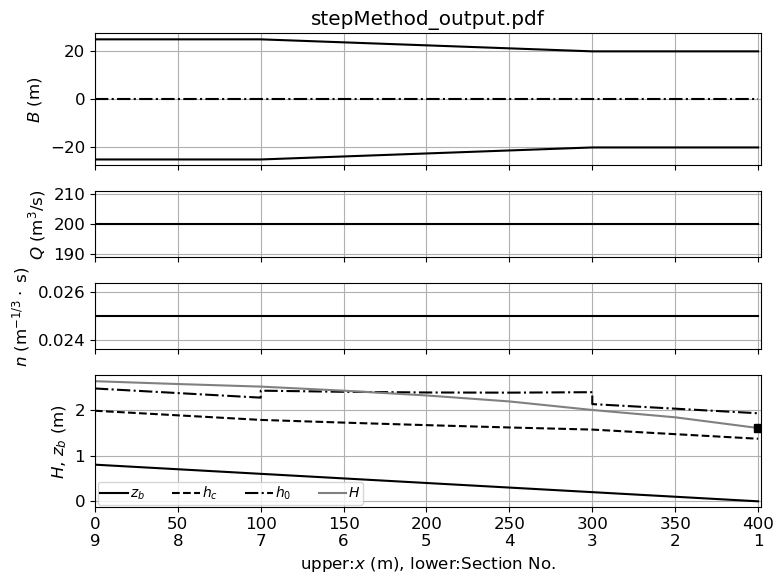

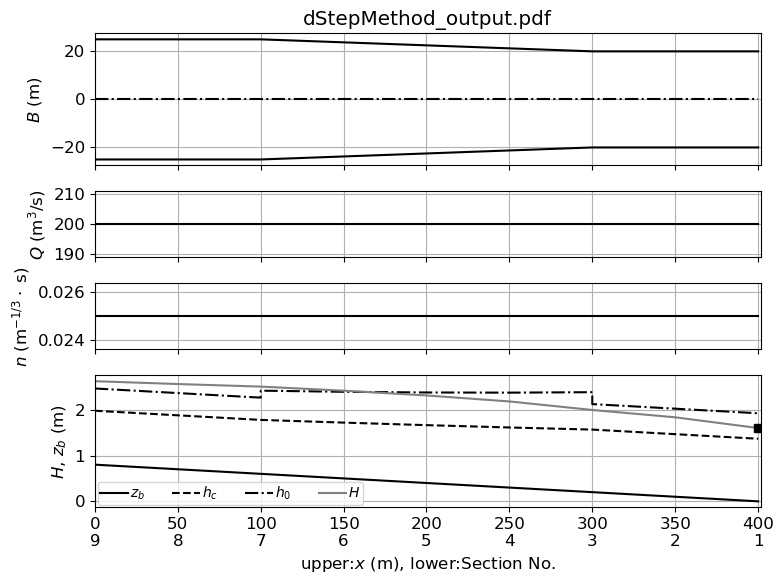

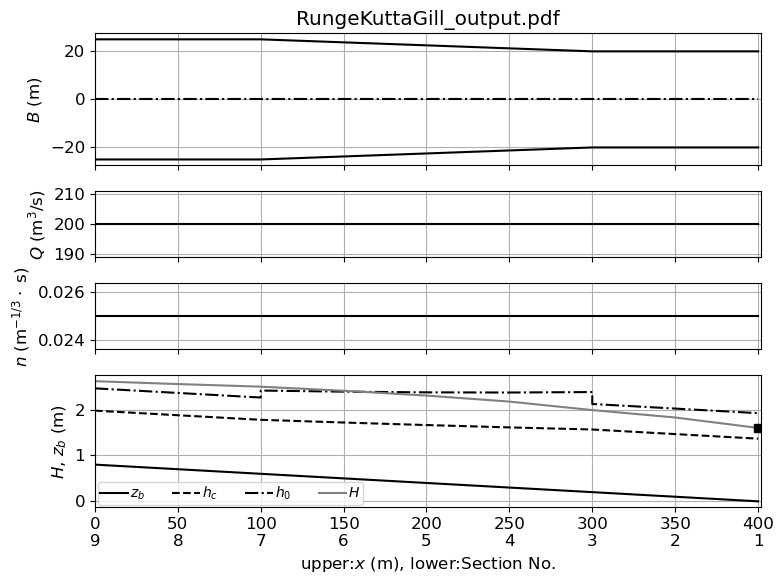

In [8]:
if __name__ == "__main__":
    """main関数"""
    # 入力ファイル名の設定(入力条件は全てexcelファイルに記載)
    inputFileName = "inputData.xlsx"
    # ------------
    # 標準逐次近似法
    # ------------
    outPutFileName = "stepMethod"
    stepMethod = StepMethod(inputFileName)
    stepMethod.calcWL()
    stepMethod.writeData(outPutFileName)
    # グラフの作成
    graph = Graph(outPutFileName, stepMethod)
    graph.graphPlot()
    del stepMethod
    # ------------
    # 直接逐次近似法
    # ------------
    outPutFileName = "dStepMethod"
    dStepMethod = DirectStepMethod(inputFileName)
    dStepMethod.calcWL()
    dStepMethod.writeData(outPutFileName)
    # グラフの作成
    graph = Graph(outPutFileName, dStepMethod)
    graph.graphPlot()
    del dStepMethod
    # ------------------
    # Runge-Kutta-Gill法
    # ------------------
    outPutFileName = "RungeKuttaGill"
    rungeKuttaGill = RungeKuttaGill(inputFileName)
    rungeKuttaGill.calcWL()
    rungeKuttaGill.writeData(outPutFileName)
    # グラフの作成
    graph = Graph(outPutFileName, rungeKuttaGill)
    graph.graphPlot()
    del rungeKuttaGill